In [1]:
from skimage import io
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.decomposition import PCA
from skimage.transform import warp
from useful_functions import *

## PCA ANALYSIS

- Compute data from dir into matrix
- Find average image
- Compute SSD (Sum of Squared Distances) to find the most similar img
- Fast PCA
- Project the images into PCA space
- Find specific images in the pca plot (nearest, furthest and specific ones)
- Matrix cleaning
- Creating images from PCA analysis
- See variation of the PC components
- Find images corresponding to the most and least variation from the specific image


In [ ]:
# Compute data into matrix -> create a matrix of vectors with length h*w*ch

files = glob.glob(f"{preprocess_dir}/*.jpg")

height, width, channels = io.imread(files[0]).shape
data_matrix = np.zeros((len(files), height * width * channels))
for i, f in enumerate(files):
    data_matrix[i, :] = io.imread(f).flatten()

In [ ]:
# create mean visualization of the matrix
average_cat = np.mean(data_matrix, axis=0)

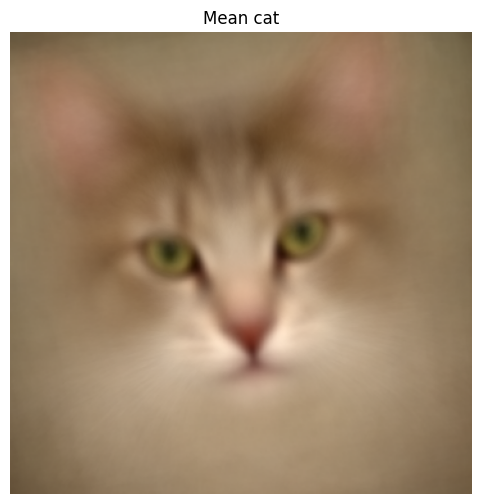


Subtract you missing img data from all the rows in the data_matrix and for each row compute the **sum of squared differences**.

Then to find the training img that looks most like your missing img by finding the vector, where the SSD is smallest. You can for example use `np.argmin`.


In [ ]:
sub_data = data_matrix - im_miss_flat
sub_distances = np.linalg.norm(sub_data, axis=1)

min_idx = np.argmin(sub_distances)
# data_matrix[min_idx,:] contains the most similar img_vector to the selected one

Fast PCA


In [ ]:
# Computing PCA with standardization
cats_pca = PCA(n_components=50)
cats_pca.fit(data_matrix)

# plot explained variance for the components
explained_variance = cats_pca.explained_variance_ratio_
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(explained_variance)
ax[0].set_ylabel("Ratio of explained variance")
ax[0].set_xlabel("Component number")
ax[1].plot(explained_variance.cumsum())
ax[1].set_ylabel("Accumulative explained variance")
ax[1].set_xlabel("Number of components")
plt.show()

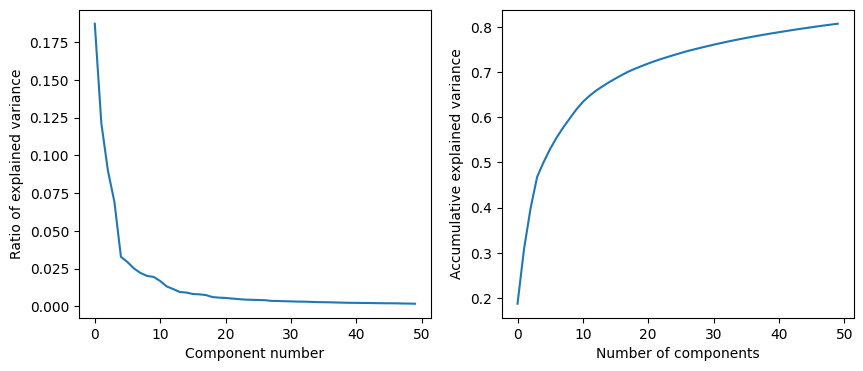


In [ ]:
# Project the images into PCA space
components = cats_pca.transform(data_matrix)

# Plot the PCA space by plotting all the imgaes first and second PCA coordinates in a (x, y) plot
pc_1 = components[:, 0]
pc_2 = components[:, 1]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(pc_1, pc_2, "o")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.show()

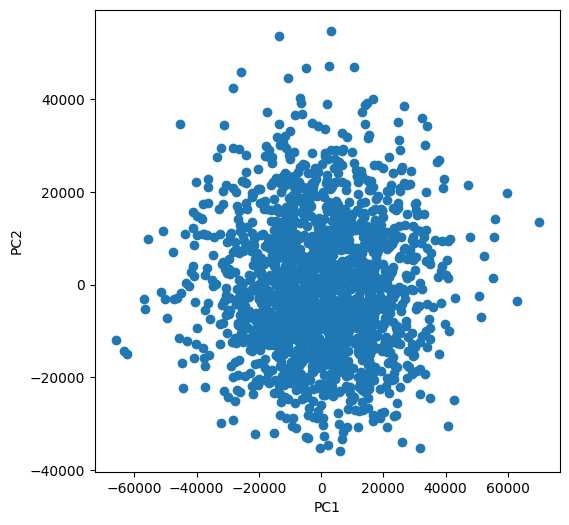


These functions let you inspect the plot above, in order to check the n most extreme values of the plot (min and max).

The last func plots the images correspondent and the plot with the dot highlighted.


In [ ]:
def nargmax(arr, n):
    # Like np.argmax but returns the n largest values
    idx = np.argpartition(arr, -n)[-n:]
    return idx[np.argsort(arr[idx])][::-1]


def nargmin(arr, n):
    # Like np.argmin but returns the n smallest values
    idx = np.argpartition(arr, n)[:n]
    return idx[np.argsort(arr[idx])]


def plot_pca_space_and_img(pc_idx):
    _, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].plot(pc_1, pc_2, "o")
    ax[0].plot(pc_1[pc_idx], pc_2[pc_idx], "ro", markersize=10)
    ax[0].set_xlabel("PC1")
    ax[0].set_ylabel("PC2")

    img = create_u_byte_image_from_vector(
        data_matrix[pc_idx, :], height, width, channels
    )
    ax[1].imshow(img)
    ax[1].set_title("Cat")
    ax[1].set_axis_off()
    plt.show()

In [ ]:
# EXAMPLE OF USE
# Check the 4 largest values of PC1
max_pc1s = nargmax(pc_1, 4)
for i in max_pc1s:
    plot_pca_space_and_img(i)

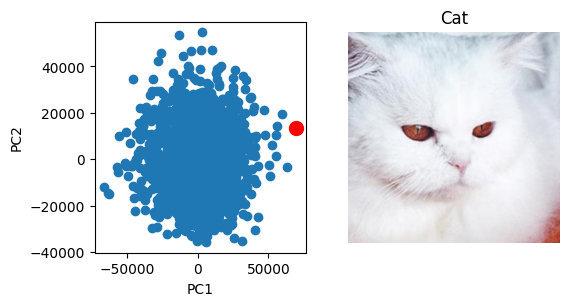


Removing the data that are not good enough from the matrix


In [ ]:
filtered_matrix = data_matrix.copy()

# Remove the 8 largest values of PC1, 5 smallest values of PC1,
# 5 largest values of PC2 and 5 smallest values of PC2
max_pc1s = nargmax(pc_1, 8)
min_pc1s = nargmin(pc_1, 5)
max_pc2s = nargmax(pc_2, 5)
min_pc2s = nargmin(pc_2, 5)

remove_idx = np.concatenate((max_pc1s, min_pc1s, max_pc2s, min_pc2s))
filtered_matrix = np.delete(filtered_matrix, remove_idx, axis=0)

# Recompute PCA
cats_pca = PCA(n_components=50)
cats_pca.fit(filtered_matrix)
components = cats_pca.transform(filtered_matrix)

Create a fake image from the filtered data matrix and the pca


In [ ]:
# Using just PC1
w = 60000
synth_cat = average_cat + w * cats_pca.components_[0, :]

# Using PC1 and PC2
w0, w1 = 60000, 60000
synth_cat = (
    average_cat + w0 * cats_pca.components_[0, :] + w1 * cats_pca.components_[1, :]
)

synth_cat_img = create_u_byte_image_from_vector(synth_cat, height, width, channels)
plt.imshow(synth_cat_img)
plt.show()

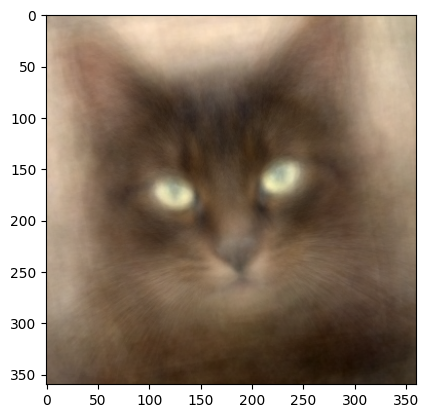


This func let you visualize the mode of variation of the m PC


In [ ]:
def visualize_mode_of_variation(m):
    synth_cat_plus = (
        average_cat
        + 3 * np.sqrt(cats_pca.explained_variance_[m]) * cats_pca.components_[m, :]
    )
    synth_cat_minus = (
        average_cat
        - 3 * np.sqrt(cats_pca.explained_variance_[m]) * cats_pca.components_[m, :]
    )

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(
        create_u_byte_image_from_vector(synth_cat_minus, height, width, channels)
    )
    ax[0].set_title("Cat - 3$\sigma$")
    ax[1].imshow(create_u_byte_image_from_vector(average_cat, height, width, channels))
    ax[1].set_title("Average cat")
    ax[2].imshow(
        create_u_byte_image_from_vector(synth_cat_plus, height, width, channels)
    )
    ax[2].set_title("Cat + 3$\sigma$")
    fig.suptitle("Mode of variation PC{}".format(m + 1))

Example
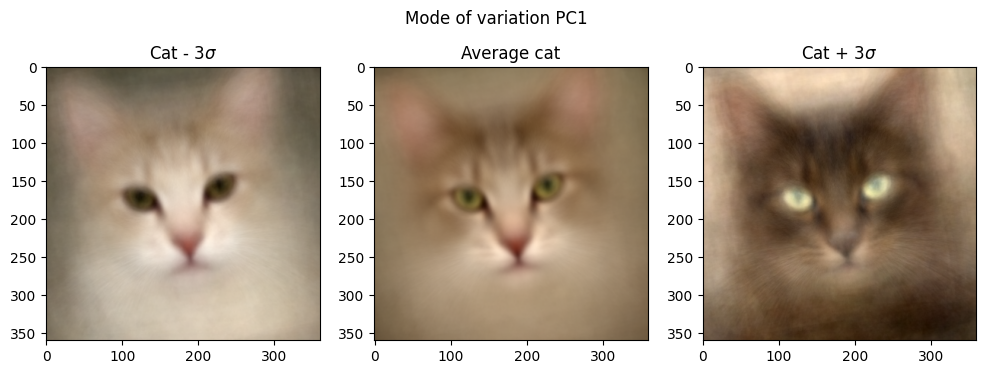


In [ ]:
# Generate random image from the datamatrix and the pca analysis
def random_cat_generator():
    w = np.random.randn(50) * 50000
    w = w * np.exp(-np.arange(50))  # Decrease the influence of the higher PCs
    synth_cat = average_cat + np.dot(w, cats_pca.components_)
    return create_u_byte_image_from_vector(synth_cat, height, width, channels)

Identify the missing img in the PCA plot


In [ ]:
im_miss = io.imread("data/MissingCatProcessed.jpg")
im_miss_flat = im_miss.flatten()
im_miss_flat = im_miss_flat.reshape(1, -1)
pca_coords = cats_pca.transform(im_miss_flat)
pca_coords = pca_coords.flatten()

components = cats_pca.transform(filtered_matrix)
pc_1 = components[:, 0]
pc_2 = components[:, 1]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(pc_1, pc_2, "o")
ax.plot(pca_coords[0], pca_coords[1], "ro", label="Missing cat")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.legend()
plt.show()

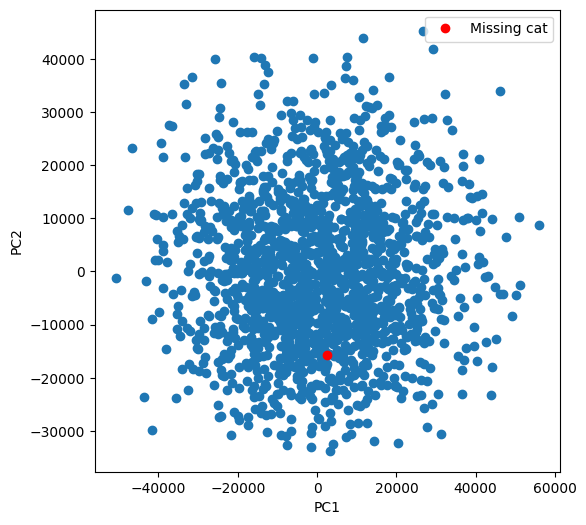


In [ ]:
n_components_to_use = 10
synth_cat = average_cat
for idx in range(n_components_to_use):
    synth_cat = synth_cat + pca_coords[idx] * cats_pca.components_[idx, :]

After this you can create a vector from ubyte and have your image of the nearest and the furthes dot in the plot


In [ ]:
comp_sub = components - pca_coords
pca_distances = np.linalg.norm(comp_sub, axis=1)

best_match = np.argmin(pca_distances)
best_twin_cat = data_matrix[best_match, :]
worst_match = np.argmax(pca_distances)
worst_twin_cat = data_matrix[worst_match, :]

In [ ]:
# 5 most nearest dot in the plot
n_best = 5
best = np.argpartition(pca_distances, n_best)
fig, ax = plt.subplots(ncols=n_best, figsize=(16, 4))
for i in range(n_best):
    candidate_twin_cat = data_matrix[best[i], :]
    ax[i].imshow(
        create_u_byte_image_from_vector(candidate_twin_cat, height, width, channels)
    )
    ax[i].axis("off")